In [1]:
## Display Hardware used for training and testing the model 
import torch 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device: cuda
NVIDIA GeForce RTX 2060


In [2]:
## Imports 
## Below code is borrowed from pytorch tutorial (https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) and modifed as per requirement.
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import shutil



plt.ion()

In [3]:
## Extract data set from zip file

# import zipfile
# with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
#     zip_ref.extractall('.')
    


In [4]:
## prepare data set into train, test and validation

## label map 

labels_map = {
    '1': "glass",
    '2': "paper",
    '3': "cardboard",
    '4': "plastic",
    '5': "metal",
    '6': "trash"
}

def make_dir():
    for i in ['train','test','val']:
        parent_dir = "GarbageHarvester/"
        for j in labels_map.values():
            directory=i+'/'+j
            path = os.path.join(parent_dir, directory)
            if not os.path.exists(path):
                os.mkdir(path)

def organize_dataset(datasettype):
    make_dir()
    with open('one-indexed-files-notrash_'+datasettype+'.txt') as f:
        line = f.readline()
        while line:
            line = f.readline()
            l= line.split(' ')
            cleanlist= list(map(lambda x:x.strip(),l))
            print(labels_map[cleanlist[1]])
            shutil.copyfile('Garbageclassification/'+labels_map[cleanlist[1]]+'/'+cleanlist[0], 'GarbageHarvester/'+datasettype+'/'+labels_map[cleanlist[1]]+'/'+cleanlist[0])

## Run only once else it will cause exception. need to fix this bug later.
#organize_dataset('train')         
#organize_dataset('test')         
#organize_dataset('val')         



In [5]:
# Data Preparation 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'GarbageHarvester'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train','test','val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=6,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test','val']}
print(dataset_sizes)
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


{'train': 1767, 'test': 430, 'val': 327}


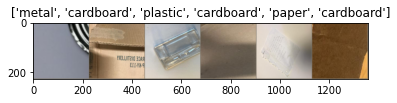

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            if phase == 'test':
                model.eval()
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.2792 Acc: 0.5076
test Loss: 1.1175 Acc: 0.5930
val Loss: 1.1739 Acc: 0.5719

Epoch 1/24
----------
train Loss: 1.0149 Acc: 0.6248
test Loss: 0.8995 Acc: 0.6721
val Loss: 0.8709 Acc: 0.6636

Epoch 2/24
----------
train Loss: 0.8943 Acc: 0.6684
test Loss: 0.9331 Acc: 0.7279
val Loss: 0.9037 Acc: 0.7156

Epoch 3/24
----------
train Loss: 0.8034 Acc: 0.7097
test Loss: 0.7843 Acc: 0.6930
val Loss: 0.8078 Acc: 0.6881

Epoch 4/24
----------
train Loss: 0.7176 Acc: 0.7470
test Loss: 0.5954 Acc: 0.7977
val Loss: 0.5620 Acc: 0.8165

Epoch 5/24
----------
train Loss: 0.6441 Acc: 0.7685
test Loss: 0.5868 Acc: 0.8279
val Loss: 0.5237 Acc: 0.8410

Epoch 6/24
----------
train Loss: 0.5953 Acc: 0.7974
test Loss: 0.5621 Acc: 0.8116
val Loss: 0.6231 Acc: 0.8104

Epoch 7/24
----------
train Loss: 0.3731 Acc: 0.8676
test Loss: 0.3853 Acc: 0.8512
val Loss: 0.4020 Acc: 0.8746

Epoch 8/24
----------
train Loss: 0.2971 Acc: 0.8987
test Loss: 0.3695 Acc: 0.8628
val Loss: 0.3

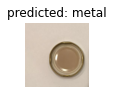

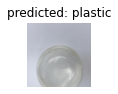

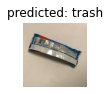

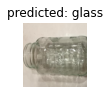

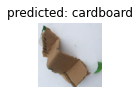

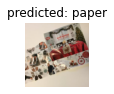

In [11]:
visualize_model(model_ft)
